In [12]:
%matplotlib inline
import numpy as np
from sklearn.linear_model import LinearRegression
import pymysql
import pandas as pd
import scipy
import sys, io, os
sys.path.append(os.path.abspath(os.path.dirname('../code/')))
from Database import Database, Partition
import CostFunction
import seaborn
import matplotlib.pyplot as plt

In [2]:
partition = Partition('PA')
database = Database(partition)
costfunction = CostFunction.CostFunction(database)

In [3]:
connection = pymysql.connect(user='root', password='root',
                              host='localhost',
                              db='drug_database')

info_connection = pymysql.connect(user='root', password='root',
                                 host='localhost',
                                 db='drug_information')

presc_connection = pymysql.connect(user='root', password='root',
                                 host='localhost',
                                 db='prescription_aggregates')

aggregate_connection = pymysql.connect(user='root', password='root',
                                 host='localhost',
                                 db='drug_aggregates')
opt_connection = pymysql.connect(user='root', password='root',
                                 host='localhost',
                                 db='optimization_tables')

In [4]:
selected_specialty = 'Allergy/Immunology'
selected_drug = 'XOLAIR'

def get_observation_values(selected_specialty, selected_drug):
    cursor = info_connection.cursor()
    cursor.execute("""
    SELECT npi, specialty_description, drug_name, total_claim_count, total_day_supply, drug_cost,
    total_claim_count / drug_cost as claim_per_dollar, total_day_supply / total_claim_count as supply_per_claim,
    drug_cost / total_claim_count as cost_per_claim
    FROM pa_state_spl_drug_npi
    WHERE specialty_description = '{0}' AND drug_name = '{drug_name}'
    """.format(selected_specialty, drug_name=selected_drug))
    specialty_values = cursor.fetchall()
    cursor.close()
    return specialty_values

In [5]:
def get_mean_values(selected_specialty, selected_drug):
    cursor = opt_connection.cursor()
    cursor.execute("""
    SELECT pa_cost_function.npi, pa_cost_function.specialty_description, pa_cost_function.drug_name,
    specialty_mean_claim_per_dollar, specialty_mean_supply_per_claim, specialty_mean_cost_per_claim,
    specialty_std_claim_per_dollar, specialty_std_supply_per_claim, specialty_std_cost_per_claim,
    drug_mean_claim_per_dollar, drug_mean_supply_per_claim, drug_mean_cost_per_claim,
    drug_std_claim_per_dollar, drug_std_supply_per_claim, drug_std_cost_per_claim
    FROM pa_cost_function 
    INNER JOIN drug_information.pa_state_spl_drug_npi ON
    pa_state_spl_drug_npi.specialty_description = pa_cost_function.specialty_description
    AND pa_state_spl_drug_npi.drug_name = pa_cost_function.drug_name
    WHERE pa_cost_function.specialty_description = '{0}' AND pa_cost_function.drug_name = '{drug_name}'
    GROUP BY pa_state_spl_drug_npi.specialty_description, pa_state_spl_drug_npi.drug_name
    """.format(selected_specialty, drug_name=selected_drug))
    aggregated_values = cursor.fetchone()
    cursor.close()
    return aggregated_values

In [11]:
# MMSE when only specialties are taken into consideration
# Safety Observation values
specialty_values = get_observation_values(selected_specialty, selected_drug)
y_values = np.array(specialty_values)
measurement_values = np.array(y_values[:, 6:], dtype=np.dtype(np.float64))
y_mean = np.mean(measurement_values, axis=0)

new_specialty = 'Physician Assistant'
new_drug = 'NOVOLOG'
observation = get_observation_values(new_specialty, new_drug)
x_values = np.array(observation)
estimation_values = np.array(x_values[:, 6:], dtype=np.dtype(np.float64))
x_mean = np.mean(estimation_values, axis=0)
mean_value_items = np.array(get_mean_values(new_specialty, new_drug))
estimation_mean_values = np.array(mean_value_items[3:], dtype=np.dtype(np.float64))
phi_mean = np.array([estimation_mean_values[0], estimation_mean_values[1], estimation_mean_values[2]])

covariance_matrix = np.cov(np.mean(np.square(estimation_values[:, 0:2] - phi_mean[0:2]), axis=0), 
                     np.mean(np.square(measurement_values[:, 0:2] - phi_mean[0:2]), axis=0))

cov_xy = covariance_matrix[0, 1]
cov_y = covariance_matrix[1, 1]

# MMSE vector for Safety and Claim per Dollar (used for calculating local optima and maxima)
x_cap_claim_per_dollar = x_mean[0] + (cov_xy / cov_y) * (measurement_values[:, 0] - y_mean[0])

# MMSE vector for Safety and Supply per Claim
x_cap_supply_per_claim = x_mean[1] + (cov_xy / cov_y) * (measurement_values[:, 1] - y_mean[1])

# MSE estimation (takes global mean into perspective)
phi_cap_claim_per_dollar = phi_mean[0] + ( cov_xy / cov_y ) * (measurement_values[:, 0] - y_mean[0])
phi_cap_supply_per_claim = phi_mean[1] + ( cov_xy / cov_y ) * (measurement_values[:, 1] - y_mean[1])

print("Measurement ('Allergy/Immunology', 'XOLAIR') v/s Observation ('Physician Assistant', 'NOVOLOG')", "\n")
print("The Average of Mean Square Estimation (MSE) Value is: ", 
      np.mean(np.array([phi_cap_claim_per_dollar, phi_cap_supply_per_claim]), axis=1), "\n")
print("The Average of Mimnimum Mean Square Estimation (MMSE) Value is: ", 
      np.mean(np.array([x_cap_claim_per_dollar, x_cap_supply_per_claim]), axis=1))

Measurement ('Allergy/Immunology', 'XOLAIR') v/s Observation ('Physician Assistant', 'NOVOLOG') 

The Average of Mean Square Estimation (MSE) Value is:  [  0.04874205  34.11916814] 

The Average of Mimnimum Mean Square Estimation (MMSE) Value is:  [  2.32244359e-03   3.39411528e+01]


There is a demarcation from estimation and expectation, but MMSE with linear measurements provide an equivalence relation between the MMSE functor and the Expectation ( Observation given Measurement )

**Expectation ( Observation given Measurement ) is given by 
Quantity * Probability ( Observation given Measurement )**

From the Bayesian Inference,

**Probability ( Observation given Measurement ) is taken as:
Probability ( Observation and Measurement ) / Probability (Measurement)**

In [14]:
total_batches = None
cursor = database.opt_connection.cursor()
cursor.execute("""
SELECT COUNT(DISTINCT batch, cluster) FROM pa_kmeans_y_pred_spl_weight;
""")
total_batches = cursor.fetchone()[0]
cursor.close()

def find_classes(prescription):
    cursor = database.opt_connection.cursor()
    cursor.execute("""
    SELECT COUNT(DISTINCT batch, cluster) as batch_cluster
    FROM pa_kmeans_y_pred_spl_weight
    WHERE drug_name = '{0}' AND specialty_description = '{1}'; """.format(prescription[0], prescription[1]))
    item = cursor.fetchone()
    cursor.close()
    return item[0]

def find_joint_classes(prescription, existing_prescription):
    cursor = database.opt_connection.cursor()
    cursor.execute("""
    SELECT COUNT(DISTINCT batch, cluster) as batch_cluster
    FROM pa_kmeans_y_pred_spl_weight
    WHERE (drug_name = '{0}' AND specialty_description = '{1}')
    OR (drug_name = '{2}' AND specialty_description = '{3}')
    """.format(prescription[0], prescription[1], existing_prescription[0], existing_prescription[1]))
    item = cursor.fetchone()
    cursor.close()
    return item[0]

def probability_specialty_drug(prescription):
    global total_batches
    cursor = database.info_connection.cursor()
    cursor.execute("""
    SELECT COUNT(DISTINCT npi) as count FROM """ + partition.state + 
    """_state_spl_drug_npi WHERE drug_name = '{drug_name}' AND 
    specialty_description = '{specialty_description}'
    """.format(drug_name=prescription[0], 
        specialty_description=prescription[1]))
    drug_name = prescription[0]
    specialty_description = prescription[1]

    batch_cluster_sum = find_classes(prescription)

    result = cursor.fetchone()
    specialty_drug_total = result[0]
    cursor.close()

    cursor = database.info_connection.cursor()
    cursor.execute("""
    SELECT COUNT(DISTINCT npi) as count FROM """ + partition.state + """_state_spl_drug_npi
    WHERE drug_name = '{drug_name}'
    """.format(drug_name=drug_name))
    result = cursor.fetchone()
    drug_total = result[0]
    cursor.close()

    return {'calculated_probability': batch_cluster_sum * specialty_drug_total / (total_batches * drug_total),
           'batch_cluster_sum': batch_cluster_sum,
            'specialty_drug_total': specialty_drug_total,
            'drug_total': drug_total
           }

def joint_probability_specialty_drug(prescription, existing_prescription):
    global total_batches
    x_prescription_combination = probability_specialty_drug(prescription)
    y_prescription_combination = probability_specialty_drug(existing_prescription)

    net_cases = x_prescription_combination['specialty_drug_total'] + y_prescription_combination['specialty_drug_total']
    net_drug_cases = x_prescription_combination['drug_total'] + y_prescription_combination['drug_total']
    batches_sum = find_joint_classes(prescription, existing_prescription)
    return {
        'net_cases': net_cases,
        'calculated_probability': batches_sum * net_cases / (total_batches * net_drug_cases),
        'net_drug_cases': net_drug_cases,
        'batches_sum': batches_sum,
        'net_y_cases': y_prescription_combination['specialty_drug_total']
    }

In [15]:
measurement_pair = ('XOLAIR', 'Allergy/Immunology')
observation_pair = ('NOVOLOG', 'Physician Assistant')

# Safety and Claim per Dollar
measurement_quantity = measurement_values[:, 0]
observation_quantity = estimation_values[:, 0]

# Probability
prob_measurement = probability_specialty_drug(measurement_pair)['calculated_probability']
prob_measurement_observation = joint_probability_specialty_drug(
    measurement_pair, observation_pair)['calculated_probability']
prob_observation = probability_specialty_drug(observation_pair)['calculated_probability']

claim_observation_quantity = observation_quantity

In [27]:
# Observation
claim_observation_expectation = claim_observation_quantity * prob_measurement_observation / prob_measurement

# Measurement (for Reference)
measurement_expectation = measurement_quantity * prob_measurement_observation / prob_observation

print("Claim per Dollar: Observation v/s Measurement: ", "\n")
print("Probability: ", prob_measurement_observation / prob_measurement)

prob_claim_per_dollar = prob_measurement_observation / prob_measurement

Claim per Dollar: Observation v/s Measurement:  

Probability:  0.5891096683935558


In [18]:
measurement_pair = ('XOLAIR', 'Allergy/Immunology')
observation_pair = ('NOVOLOG', 'Physician Assistant')

# Safety and Supply per Claim
measurement_quantity = measurement_values[:, 1]
observation_quantity = estimation_values[:, 1]

# Probability
prob_measurement = probability_specialty_drug(measurement_pair)['calculated_probability']
prob_measurement_observation = joint_probability_specialty_drug(
    measurement_pair, observation_pair)['calculated_probability']
prob_observation = probability_specialty_drug(observation_pair)['calculated_probability']

supply_observation_quantity = observation_quantity

In [28]:
# Observation
supply_observation_expectation = supply_observation_quantity * prob_measurement_observation / prob_measurement

# Measurement (for Reference)
measurement_expectation = measurement_quantity * prob_measurement_observation / prob_observation

print("Supply per Claim: Observation v/s Measurement: ", "\n")
print("Probability: ", prob_measurement_observation / prob_measurement)

prob_supply_per_claim = prob_measurement_observation / prob_measurement

Supply per Claim: Observation v/s Measurement:  

Probability:  0.5891096683935558


Measurable Quantity for Claim per Dollar


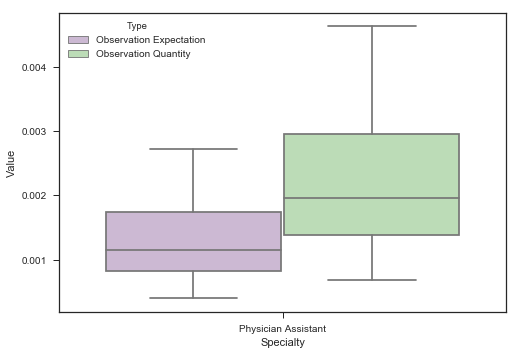

In [66]:
# Measurable Quantity for Claim per Dollar
print("Measurable Quantity for Claim per Dollar")

cursor = database.info_connection.cursor()
sql = """ SELECT npi, drug_name, specialty_description FROM """ + partition.state + """_state_spl_drug_npi WHERE drug_name = '{drug_name}' AND 
    specialty_description = '{specialty_description}'"""
cursor.execute(sql.format(drug_name=observation_pair[0], specialty_description=observation_pair[1]))
dataset = cursor.fetchall()
cursor.close()

claim_df = pd.DataFrame(columns=['Specialty', 'Observation Quantity', 'Observation Expectation'])
idx = 0
for item in claim_observation_expectation:
    claim_df = claim_df.append({
        'Specialty': dataset[idx][2],
        'Type': 'Observation Expectation',
        'Value': item
    }, ignore_index=True)
    idx = idx + 1
    
idx = 0
for item in claim_observation_quantity:
    claim_df = claim_df.append({
        'Specialty': dataset[idx][2],
        'Type': 'Observation Quantity',
        'Value': claim_observation_quantity[idx]
    }, ignore_index=True)
    idx = idx + 1

seaborn.set(style="ticks")
seaborn.boxplot(x="Specialty", y="Value", hue="Type", data=claim_df, palette="PRGn")

Measurable Quantity for Supply per Claim


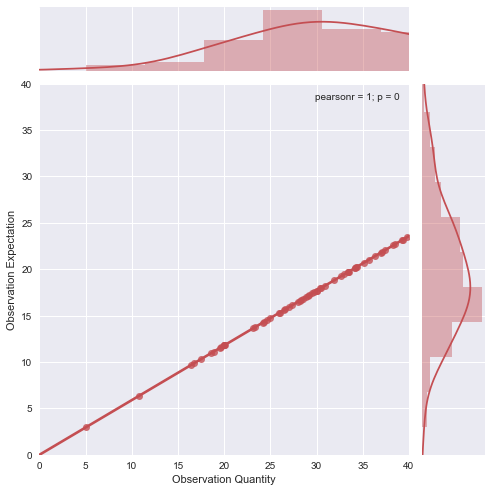

In [70]:
# Measurable Quantity for Claim per Dollar
print("Measurable Quantity for Supply per Claim")

supply_df = pd.DataFrame(columns=['NPI', 'Drug', 'Specialty Description', 'Observation Quantity', 'Observation Expectation'])
idx = 0
for item in supply_observation_expectation:
    supply_df = supply_df.append({
        'NPI': dataset[idx][0],
        'Drug': dataset[idx][1],
        'Specialty Description': dataset[idx][2],
        'Observation Quantity': supply_observation_quantity[idx],
        'Observation Expectation': item
    }, ignore_index=True)
    idx = idx + 1

seaborn.set(style="darkgrid", color_codes=True)

g = seaborn.jointplot("Observation Quantity", "Observation Expectation", data=supply_df, kind="reg",
                  xlim=(0, 40), ylim=(0, 40), color="r", size=7)

***The selection of the right measure for calculating the covariance between non-equal numbers of samples had a problem. So the verification provided below has confirmed that the covariance must be exactly what is proposed. In this case, the covariance has been calculated between 27 and 83 samples.***

In [25]:
print("The mean of the MMSE quantity", np.mean(x_cap_claim_per_dollar))

print("The Mean of the Observation Expectation", np.mean(claim_observation_expectation))

print("The Mean of the MMSE Quantity: ", np.mean(x_cap_supply_per_claim))

print("The Mean of the Observation Expectation: ", np.mean(supply_observation_expectation))

The mean of the MMSE quantity 0.00232244358678
The Mean of the Observation Expectation 0.00136817397127
The Mean of the MMSE Quantity:  33.9411528494
The Mean of the Observation Expectation:  19.9950613


In [30]:
print("The probability of Claim per Dollar as shown in the Linear Regression Plot: ", prob_claim_per_dollar)
print("The probability of Supply Per Claim: ", prob_supply_per_claim)

print("The Ratio of Expectation and MMSE Quantity (Claim per Dollar): ", 
      np.mean(claim_observation_expectation) / np.mean(x_cap_claim_per_dollar))

print("The Ratio of Expectation and MMSE Quantity (Supply per Claim): ", 
      np.mean(supply_observation_expectation) / np.mean(x_cap_supply_per_claim))

The probability of Claim per Dollar as shown in the Linear Regression Plot:  0.5891096683935558
The probability of Supply Per Claim:  0.5891096683935558
The Ratio of Expectation and MMSE Quantity (Claim per Dollar):  0.589109668394
The Ratio of Expectation and MMSE Quantity (Supply per Claim):  0.589109668394


**This demonstration is the useful documentation regarding the use of MMSE in order predict unknown variables. If a negatively classified combination of Drug and Specialty Description is required by the Medicare, then it is possible for MMSE to predict the necessary variables provided there is a deep analysis conducted by assuming the Optimality of Naive Bayes using Augmented Naive Bayes.**